# TODO

- using longest responses?

- nice figures for the 6 LLM-vs-human classifiers
- a confusion matrix for the 7-class (6 LLM + human) classifier
- mislabeled responses (or lack thereof) for GPT-3.5 vs human
- a plot showing classification accuracy as a function of GPT temp

In [1]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)

In [2]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"


authors = [HUMAN, GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]

# Function words

In [3]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    fw_oseah = [line.split()[0] for line in lines]

# fw_oseah.remove("your")

# Z-Scores

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd


class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, function_words):
        self.function_words = function_words
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # oov = [
        #    word
        #    for word in self.function_words
        #    if word not in self.vectorizer.vocabulary_
        # print(f"{len(oov)} words not in corpus: {oov}")

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)

        fw_indices = [
            self.vectorizer.vocabulary_[word]
            for word in self.function_words
            if word in self.vectorizer.vocabulary_
        ]

        # Keep the relative frquencies of only the function words
        fw_z_scores = z_scores[:, fw_indices]

        return fw_z_scores

# Deltas

In [5]:
def delta(z_scores, variant):
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

# Classification

In [14]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def classify(df, function_words, test_prompts=None, print_n_most_important=0):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    if not test_prompts:
        test_prompts = random.sample(prompt_ids, 2)

    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    df_test["y_pred"] = y_pred

    # print the words that were most important for the model
    if print_n_most_important:
        coefs = model.best_estimator_.coef_
        coefs = coefs[0]
        coefs = np.abs(coefs)
        coefs = coefs / coefs.sum()
        fw = np.array(function_words)
        fw = fw[coefs.argsort()[::-1]]
        print(fw[:print_n_most_important])

    return df_test

In [ ]:
for dataset in (["reddit"] * 5) + (["hewlett"] * 5):
    df_human = pd.read_csv("reddit_responses/human.csv")
    df_human["author"] = HUMAN
    df_gpt = pd.read_csv("reddit_responses/gpt-3.5-turbo-0125.csv")
    df_gpt["author"] = GPT_35
    df = pd.concat([df_human, df_gpt], ignore_index=True)

    classify(df, fw_oseah, print_n_most_important=10)

In [ ]:
for dataset in ["reddit", "hewlett"]:
    print(dataset)
    df_human = pd.read_csv(f"{dataset}_responses/human.csv")
    df_gpt = pd.read_csv(f"{dataset}_responses/gpt-3.5-turbo-0125.csv")

    df_human["tokens"] = df_human["text"].apply(word_tokenize)
    df_gpt["tokens"] = df_gpt["text"].apply(word_tokenize)

    # see the relative frequency of 'he' and 'she' in GPT-3.5 vs human
    words = ["he", "she", "a", "the"]
    for word in words:
        word_rel_freq_gpt = df_gpt["tokens"].apply(lambda x: x.count(word) / len(x))
        word_rel_freq_human = df_human["tokens"].apply(lambda x: x.count(word) / len(x))
        print(
            f"{word}: human: {word_rel_freq_human.mean()} gpt: {word_rel_freq_gpt.mean()}"
        )
    print()

reddit
he: human: 0.006625333485078846 gpt: 0.0021662682621693243
she: human: 0.004413168826978141 gpt: 0.012964098128293942
a: human: 0.014263125695069606 gpt: 0.027195232612212766
the: human: 0.034400312602841265 gpt: 0.06502085149060624

hewlett
he: human: 0.005037284925477697 gpt: 0.001965197994441381
she: human: 0.004390490978073949 gpt: 0.0018364145447078678
a: human: 0.017954408912960206 gpt: 0.022107849185965252
the: human: 0.04745341423057013 gpt: 0.06075187005456569



## Multiclass: all 7 authors

Running reddit trials:   0%|          | 0/5 [00:00<?, ?it/s]

Running reddit trials: 100%|██████████| 5/5 [02:15<00:00, 27.02s/it]


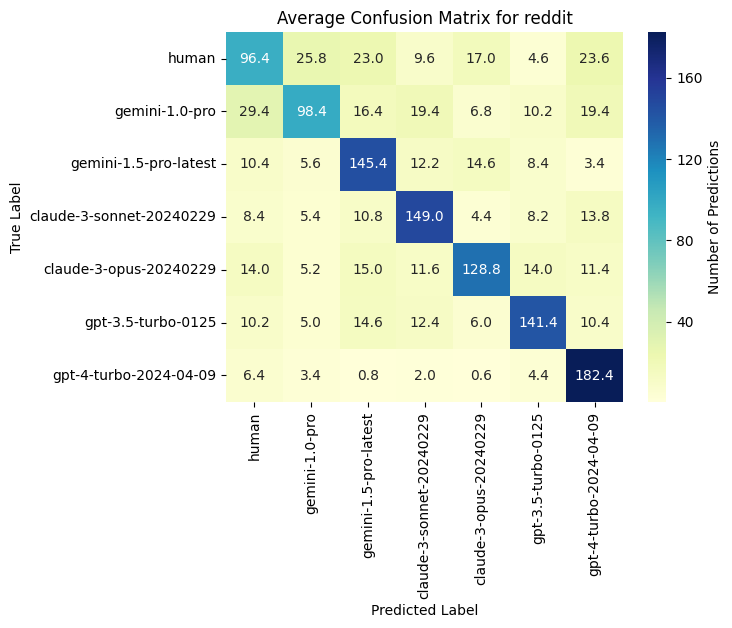

Running hewlett trials: 100%|██████████| 5/5 [02:05<00:00, 25.15s/it]


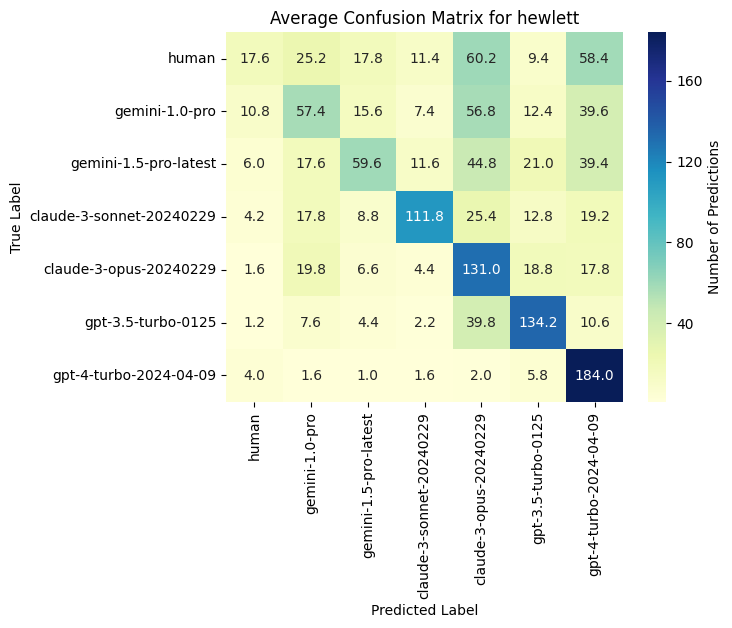

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

n_trials = 5

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    avg_conf_matrix = np.zeros((len(authors), len(authors)))
    for _ in tqdm(range(n_trials), desc=f"Running {dataset} trials"):
        df_test = classify(df, fw_oseah)
        conf_matrix = confusion_matrix(df_test["author"], df_test["y_pred"])
        avg_conf_matrix += conf_matrix

    avg_conf_matrix /= n_trials

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".1f",
        cbar_kws={"ticks": range(0, 201, 40), "label": "Number of Predictions"},
        xticklabels=authors,
        yticklabels=authors,
    )
    plt.title(f"Average Confusion Matrix for {dataset}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Pairwise with human and each LLM

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

llms = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    results = []
    for llm in tqdm(llms * n_trials):
        df_llm = pd.read_csv(f"{dataset}_responses/{llm}.csv")
        df_human = pd.read_csv(f"{dataset}_responses/{HUMAN}.csv")
        df_llm["author"] = llm
        df_human["author"] = HUMAN
        df = pd.concat([df_llm, df_human], ignore_index=True)

        df_test = classify(df, fw_oseah)
        report = classification_report(
            df_test["author"], df_test["y_pred"], zero_division=0, output_dict=True
        )
        results.append({"dataset": dataset, "llm": llm, "accuracy": report["accuracy"]})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="llm", y="accuracy", data=results_df)
    plt.title(f"{dataset.capitalize()} dataset")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.show()

# Mis-labels: GPT 3.5, human

In [ ]:
random.seed(0)
np.random.seed(0)

for dataset in ["reddit", "hewlett"]:
    prompts = list(range(8))
    llm_predicted_human = {}
    human_predicted_llm = {}

    df_human = pd.read_csv(f"{dataset}_responses/human.csv")
    df_human["author"] = HUMAN
    df_gpt_35 = pd.read_csv(f"{dataset}_responses/{GPT_35}.csv")
    df_gpt_35["author"] = GPT_40
    df = pd.concat([df_human, df_gpt_35], ignore_index=True)

    while len(llm_predicted_human) < 8 or len(human_predicted_llm) < 8:
        print(len(llm_predicted_human), len(human_predicted_llm))

        unfinished_prompts = set(
            [prompt_id for prompt_id in prompts if prompt_id not in llm_predicted_human]
            + [
                prompt_id
                for prompt_id in prompts
                if prompt_id not in human_predicted_llm
            ]
        )
        test_prompts = random.sample(list(unfinished_prompts), 2)

        df_test = classify(df, fw_oseah, test_prompts)
        for prompt_id in prompts:
            df_prompt = df_test[df_test["prompt_id"] == prompt_id]

            df_prompt_human = df_prompt[df_prompt["author"] == HUMAN]
            df_human_predicted_llm = df_prompt_human[
                df_prompt_human["y_pred"] == GPT_40
            ]
            if not df_human_predicted_llm.empty:
                human_predicted_llm[prompt_id] = df_human_predicted_llm.iloc[0]

            df_prompt_llm = df_prompt[df_prompt["author"] == GPT_40]
            df_llm_predicted_human = df_prompt_llm[df_prompt_llm["y_pred"] == HUMAN]
            if not df_llm_predicted_human.empty:
                llm_predicted_human[prompt_id] = df_llm_predicted_human.iloc[0]

In [12]:
llm_predicted_human, human_predicted_llm

({6: prompt_id                                                    6
  text         In a bustling city where powers reign supreme ...
  author                                  gpt-4-turbo-2024-04-09
  y_pred                                                   human
  Name: 300, dtype: object,
  7: prompt_id                                                    7
  text         She said she loved him, not realizing that he ...
  author                                  gpt-4-turbo-2024-04-09
  y_pred                                                   human
  Name: 305, dtype: object,
  0: prompt_id                                                    0
  text         In a distant corner of the galaxy, the peacefu...
  author                                  gpt-4-turbo-2024-04-09
  y_pred                                                   human
  Name: 248, dtype: object,
  3: prompt_id                                                    3
  text         In a quiet forest, a small deer looked aroun

In [17]:
from sklearn.metrics import classification_report

df_test = classify(df, fw_oseah, test_prompts=[0, 1])
print(classification_report(df_test["author"], df_test["y_pred"], zero_division=0))

                        precision    recall  f1-score   support

gpt-4-turbo-2024-04-09       1.00      0.99      0.99       200
                 human       0.99      1.00      1.00       200

              accuracy                           0.99       400
             macro avg       1.00      0.99      0.99       400
          weighted avg       1.00      0.99      0.99       400



# Clustering

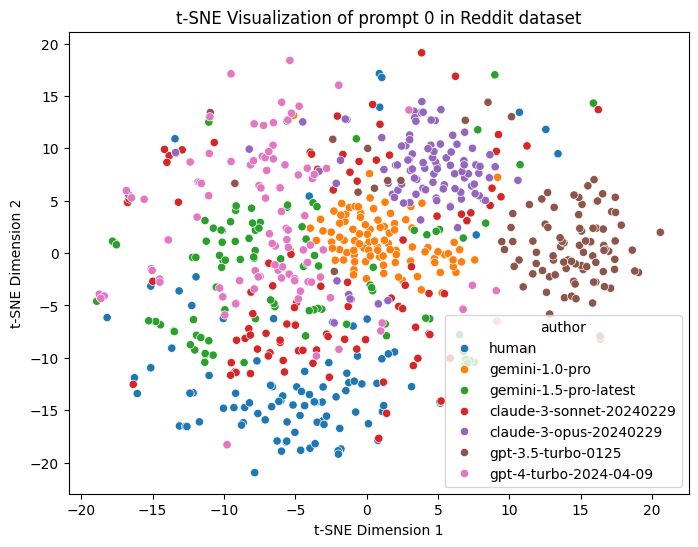

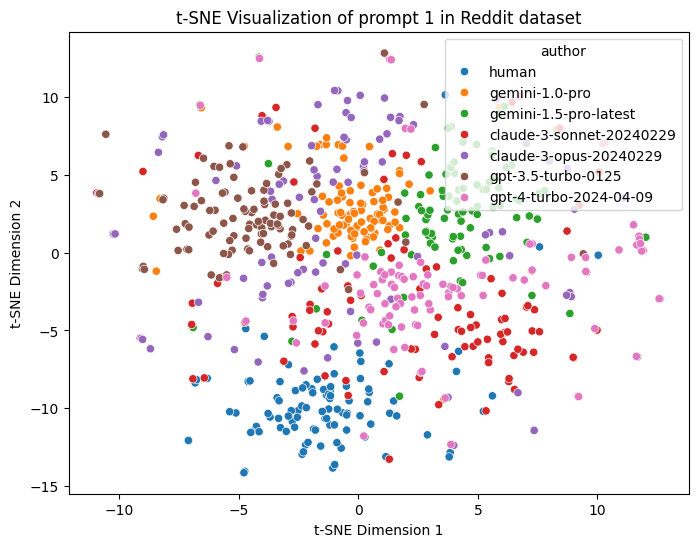

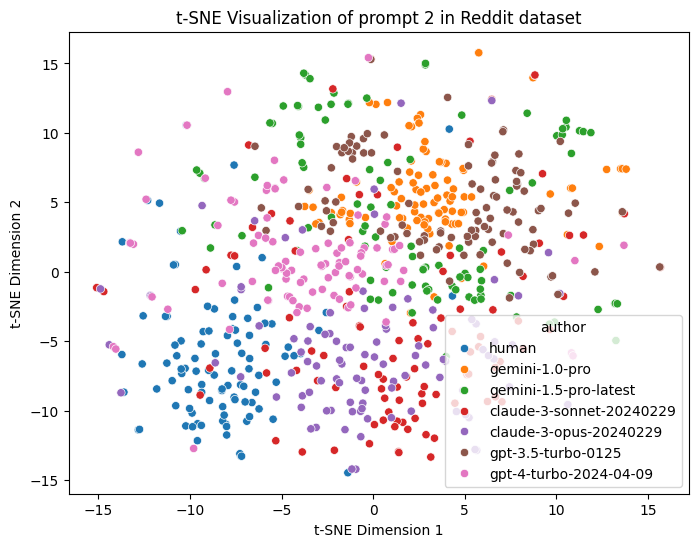

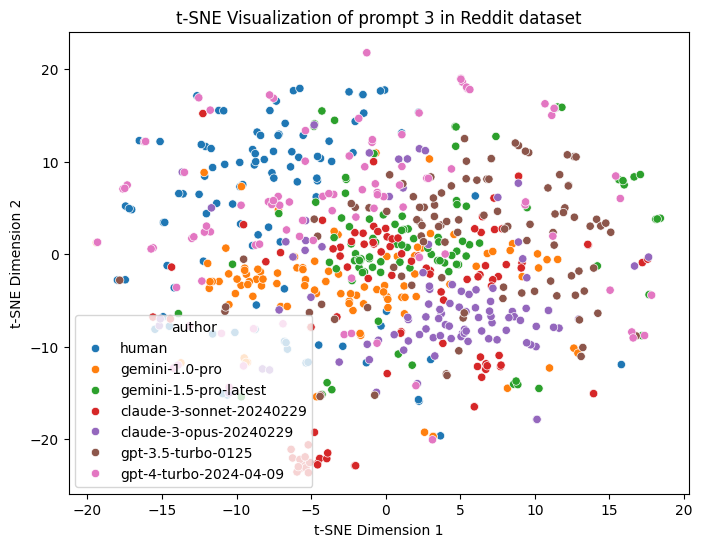

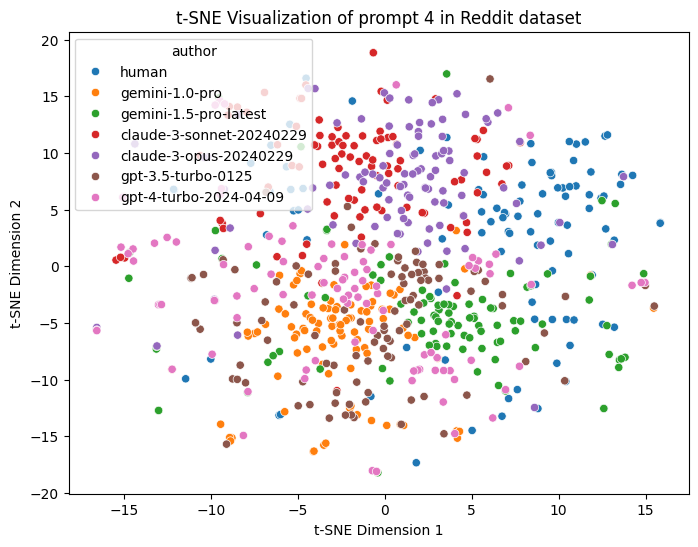

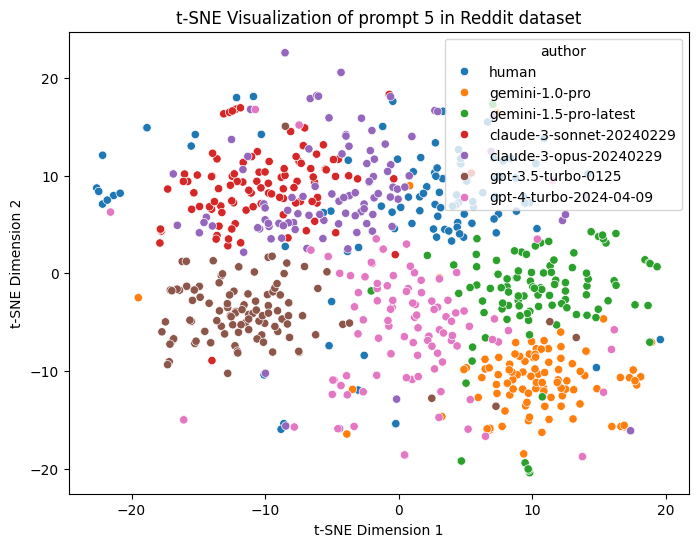

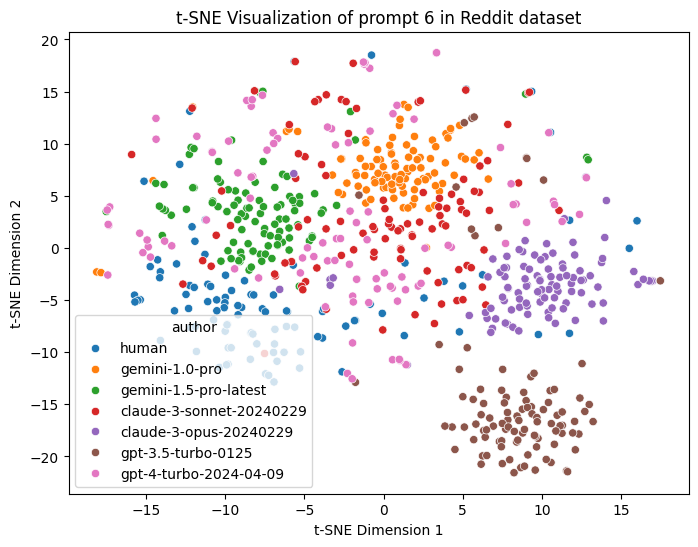

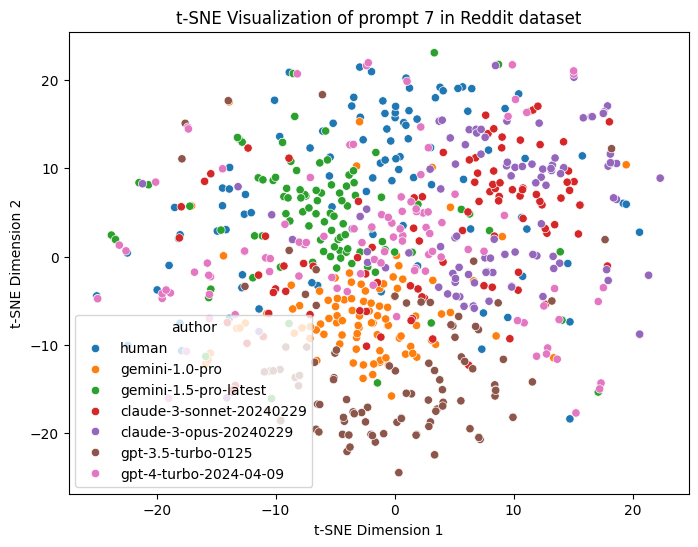

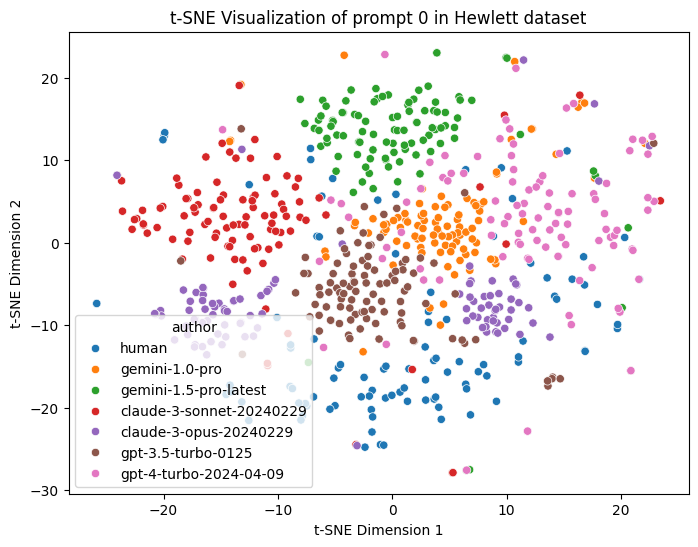

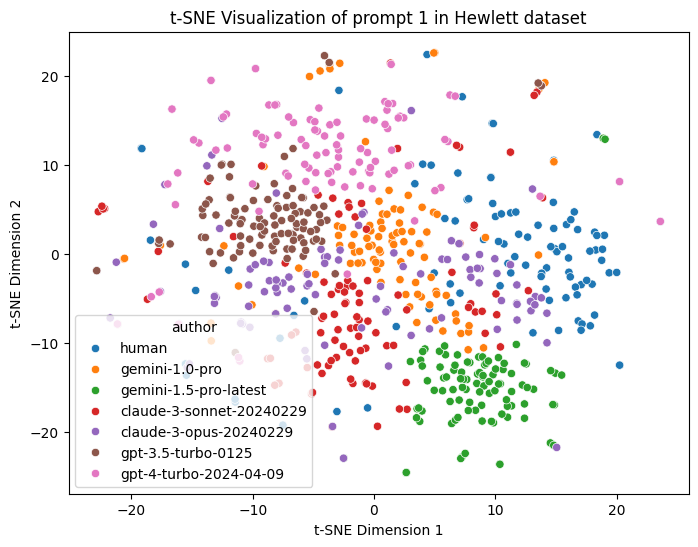

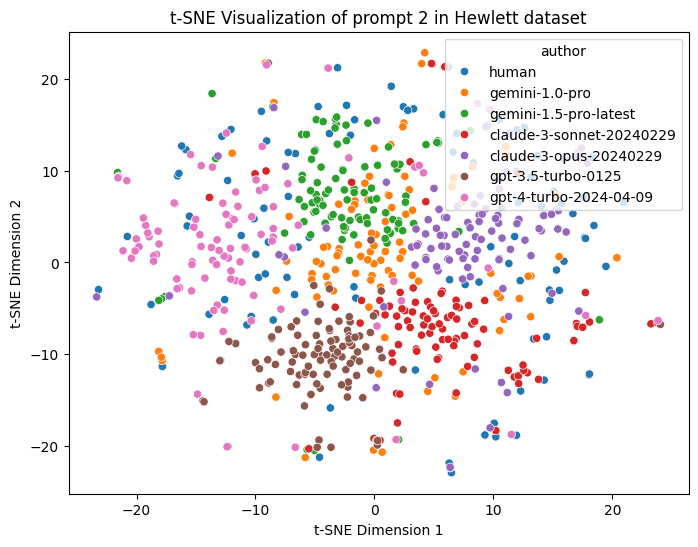

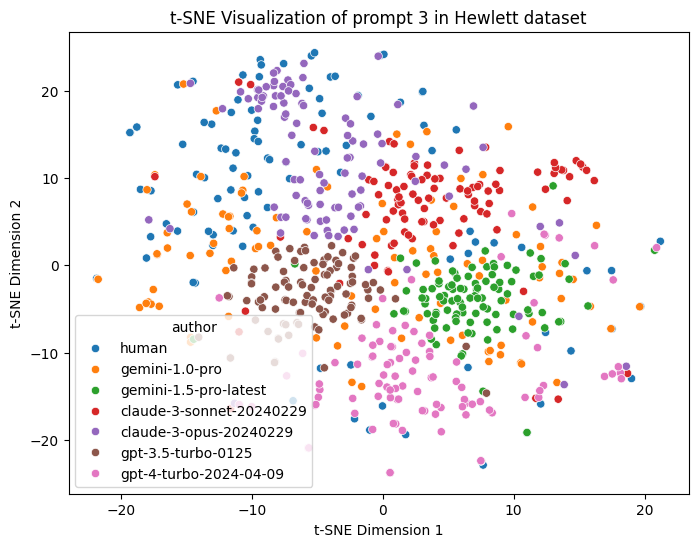

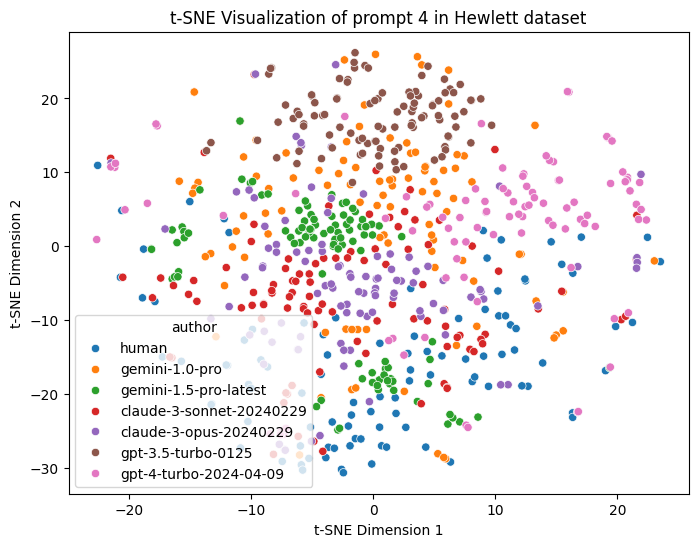

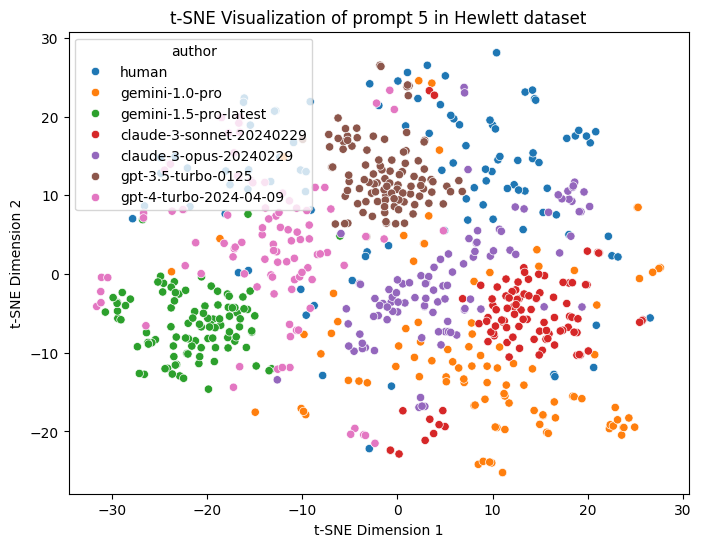

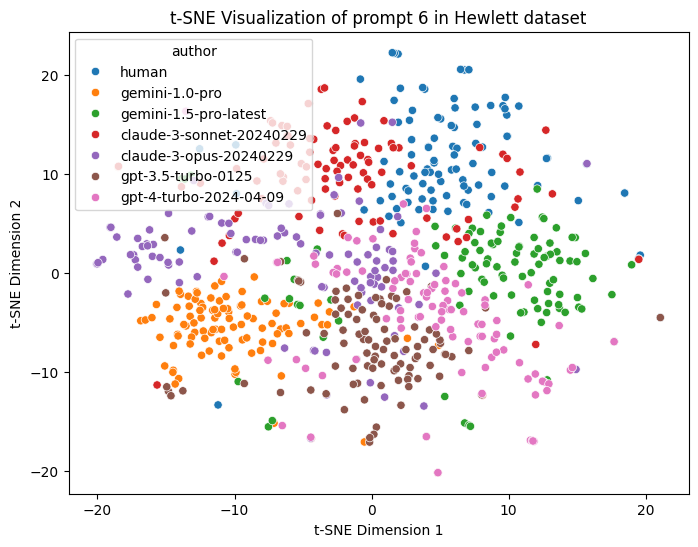

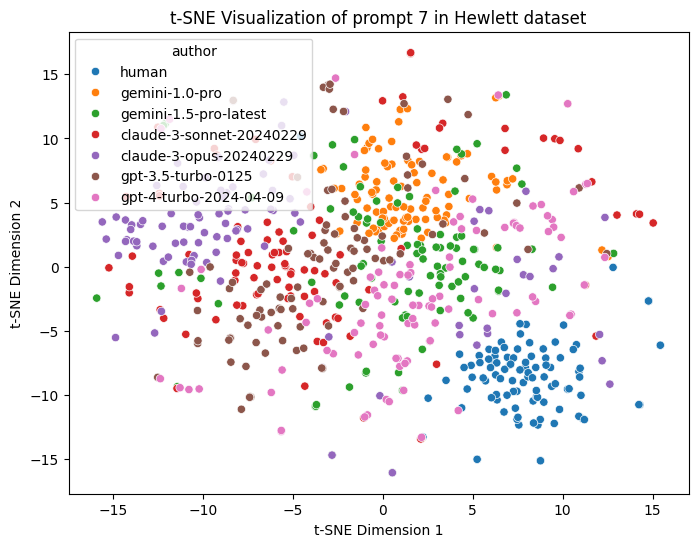

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    for prompt_id in range(8):
        dfs = []
        for author in authors:
            df = pd.read_csv(f"{dataset}_responses/{author}.csv")
            df["author"] = author
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)
        df = df[df["prompt_id"] == prompt_id]

        z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
        z_scores = z_scores_transformer.fit_transform(df["text"])

        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(z_scores)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
        plt.title(
            f"t-SNE Visualization of prompt {prompt_id} in {dataset.capitalize()} dataset"
        )
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.show()

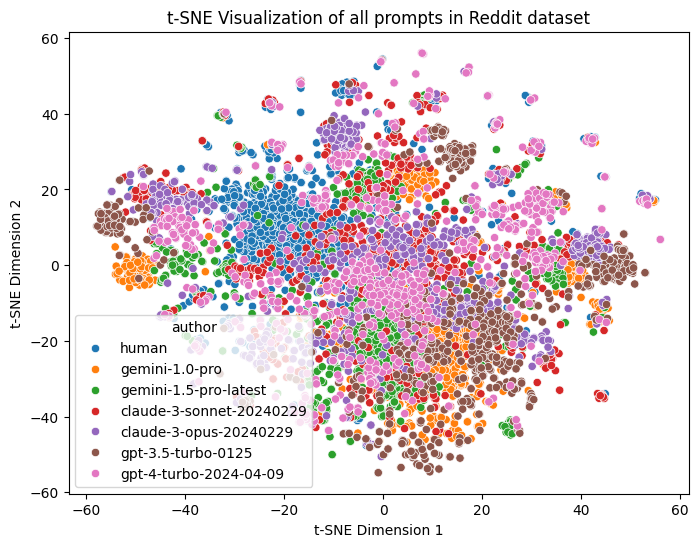

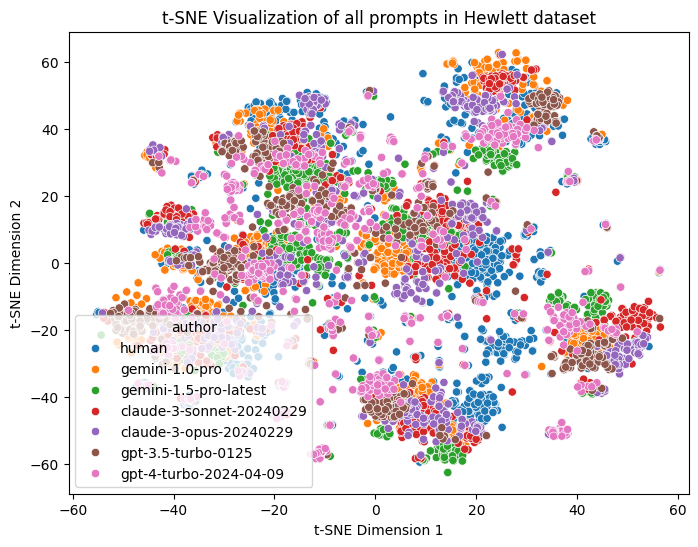

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
    z_scores = z_scores_transformer.fit_transform(df["text"])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(z_scores)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
    plt.title(f"t-SNE Visualization of all prompts in {dataset.capitalize()} dataset")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()